# Presentación de los Datos

Realizaremos el estudio de los niveles de obesidad, en función varias variables tomadas a personas de entre 14 y 61 años procedentes de los pasises de Colombia, Perú y México en 2019.

Estos datos fueron tomados mediante una encuesta anónima por internet.

La base de datos es: ObesityDataSet_raw_and_data_sinthetic.csv

Cuyo link es: https://archive.ics.uci.edu/dataset/544/estimation+of+obesity+levels+based+on+eating+habits+and+physical+condition

In [191]:
from sklearn.tree import DecisionTreeClassifier, export_text, export_graphviz, plot_tree
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import plot_confusion_matrix
from sklearn import linear_model


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from time import time

In [192]:
# Para evitar avisos innecesarios (FutureWarnings):
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

In [193]:
#Cargamos la base de datos
data = pd.read_csv('ObesityDataSet_raw_and_data_sinthetic.csv')
data.select_dtypes(include=['number','category','object'])

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.000000,1.620000,64.000000,yes,no,2.0,3.0,Sometimes,no,2.000000,no,0.000000,1.000000,no,Public_Transportation,Normal_Weight
1,Female,21.000000,1.520000,56.000000,yes,no,3.0,3.0,Sometimes,yes,3.000000,yes,3.000000,0.000000,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.000000,1.800000,77.000000,yes,no,2.0,3.0,Sometimes,no,2.000000,no,2.000000,1.000000,Frequently,Public_Transportation,Normal_Weight
3,Male,27.000000,1.800000,87.000000,no,no,3.0,3.0,Sometimes,no,2.000000,no,2.000000,0.000000,Frequently,Walking,Overweight_Level_I
4,Male,22.000000,1.780000,89.800000,no,no,2.0,1.0,Sometimes,no,2.000000,no,0.000000,0.000000,Sometimes,Public_Transportation,Overweight_Level_II
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,Female,20.976842,1.710730,131.408528,yes,yes,3.0,3.0,Sometimes,no,1.728139,no,1.676269,0.906247,Sometimes,Public_Transportation,Obesity_Type_III
2107,Female,21.982942,1.748584,133.742943,yes,yes,3.0,3.0,Sometimes,no,2.005130,no,1.341390,0.599270,Sometimes,Public_Transportation,Obesity_Type_III
2108,Female,22.524036,1.752206,133.689352,yes,yes,3.0,3.0,Sometimes,no,2.054193,no,1.414209,0.646288,Sometimes,Public_Transportation,Obesity_Type_III
2109,Female,24.361936,1.739450,133.346641,yes,yes,3.0,3.0,Sometimes,no,2.852339,no,1.139107,0.586035,Sometimes,Public_Transportation,Obesity_Type_III


Vemos que la base de datos consta de 17 atributos con 2111 entradas. Procedamos a ver cuáles son los posibles valores que puede tomar cada atributo

In [194]:
for i in data.columns:
    if len(data[i].unique()) < 8:
        print(f"{i} Es un valor discreto que toma los valores: {data[i].unique()}\n")
    else :
        print(f"{i} Es un valor continuo que va desde {min(data[i].unique())} hasta {max(data[i].unique())}\n")

Gender Es un valor discreto que toma los valores: ['Female' 'Male']

Age Es un valor continuo que va desde 14.0 hasta 61.0

Height Es un valor continuo que va desde 1.45 hasta 1.98

Weight Es un valor continuo que va desde 39.0 hasta 173.0

family_history_with_overweight Es un valor discreto que toma los valores: ['yes' 'no']

FAVC Es un valor discreto que toma los valores: ['no' 'yes']

FCVC Es un valor continuo que va desde 1.0 hasta 3.0

NCP Es un valor continuo que va desde 1.0 hasta 4.0

CAEC Es un valor discreto que toma los valores: ['Sometimes' 'Frequently' 'Always' 'no']

SMOKE Es un valor discreto que toma los valores: ['no' 'yes']

CH2O Es un valor continuo que va desde 1.0 hasta 3.0

SCC Es un valor discreto que toma los valores: ['no' 'yes']

FAF Es un valor continuo que va desde 0.0 hasta 3.0

TUE Es un valor continuo que va desde 0.0 hasta 2.0

CALC Es un valor discreto que toma los valores: ['no' 'Sometimes' 'Frequently' 'Always']

MTRANS Es un valor discreto que toma l

Debido a que 17 atributos es demasiado para la práctica a realizar cogeremos varios subconjuntos de ellos y veremos con cuáles llegamos a un mejor árbol de decisión.

Primero definiremos los atributos existentes:

* **Gender**: El género
* **Age**: La edad
* **Height**: La altura
* **Weight**: El peso
* **family_history_with_overweight**: El historial familiar de obesidad, tomará los valores 'yes' y 'no'
* **FAVC**: Frecuenta el consumo de comidad hipercalóricas, tomará valores 'yes' y 'no'
* **FCVC**: Frecuencia de consumo de vegetales
* **NCP**: Número de comidas grandes
* **CAEC**: Consumo de alimnetos entre comidas, tomará los valores 'Sometimes', 'Frequently', 'Always' y 'no'
* **SMOKE**: Consumo de tabaco, tomará valores 'yes' y 'no'
* **CH2O**: Consumo de agua diario
* **SCC**: Monitoreo del consumo calórico diario, tomará valores 'yes' y 'no'
* **FAF**: Frecuencia de actividad física 
* **TUE**: Tiempo de uso de aparátos digitales
* **CALC**: Consumo de alcohol
* **MTRANS** Medio de transporte
* **NObeyesdad**: Grado de obesidad

En el  estudio original los autores dividen los atributos en atributos relacionados con los hábitos alimenticios y los no alimenticios. Nosotros lo haremos de la misma forma, creando un árbol (o varios) para cada tipo de atributo y viendo cuál de ellos predice mejor el grado de obesidad.
Finalmente intentaremos dar el mejor árbol posible aunando los mejores parámetros.


## Atributos Alimenticios

Los atributos relacionados con los hábitos alimenticios son: FAVC, FCVC, NCP, CAEC, CH2O, CALC.
Los tomamos para nuestra nueva tabla y  separamos los valores de clasificación de los datos de clasificación

In [195]:
dataAl = data.loc[:, ["FAVC", "FCVC", "NCP", "CAEC", "CH2O", "CALC", "NObeyesdad"]]
dataAl

,FAVC,FCVC,NCP,CAEC,CH2O,CALC,NObeyesdad
0,no,2.0,3.0,Sometimes,2.000000,no,Normal_Weight
1,no,3.0,3.0,Sometimes,3.000000,Sometimes,Normal_Weight
2,no,2.0,3.0,Sometimes,2.000000,Frequently,Normal_Weight
3,no,3.0,3.0,Sometimes,2.000000,Frequently,Overweight_Level_I
4,no,2.0,1.0,Sometimes,2.000000,Sometimes,Overweight_Level_II
...,...,...,...,...,...,...,...
2106,yes,3.0,3.0,Sometimes,1.728139,Sometimes,Obesity_Type_III
2107,yes,3.0,3.0,Sometimes,2.005130,Sometimes,Obesity_Type_III
2108,yes,3.0,3.0,Sometimes,2.054193,Sometimes,Obesity_Type_III
2109,yes,3.0,3.0,Sometimes,2.852339,Sometimes,Obesity_Type_III


Los valores que puede recibir la scatter matrix deben ser númericos, así que previamente debemos hacer un cambio de valores tipo String a valores numéricos. Para ello usamos el comando factorize de Pandas



In [196]:
for i in ["FAVC","CAEC","CALC"]:
    cambio = dataAl[i].factorize()
    dataAl[i] = cambio[0]
dataAl

,FAVC,FCVC,NCP,CAEC,CH2O,CALC,NObeyesdad
0,0,2.0,3.0,0,2.000000,0,Normal_Weight
1,0,3.0,3.0,0,3.000000,1,Normal_Weight
2,0,2.0,3.0,0,2.000000,2,Normal_Weight
3,0,3.0,3.0,0,2.000000,2,Overweight_Level_I
4,0,2.0,1.0,0,2.000000,1,Overweight_Level_II
...,...,...,...,...,...,...,...
2106,1,3.0,3.0,0,1.728139,1,Obesity_Type_III
2107,1,3.0,3.0,0,2.005130,1,Obesity_Type_III
2108,1,3.0,3.0,0,2.054193,1,Obesity_Type_III
2109,1,3.0,3.0,0,2.852339,1,Obesity_Type_III


Debido a la cantidad de entradas y de valores declasificación usaremos la librería seaborn para mejorar la visualización de la scatter matrix, ya que nos da más opciones

<Figure size 1500x1500 with 0 Axes>

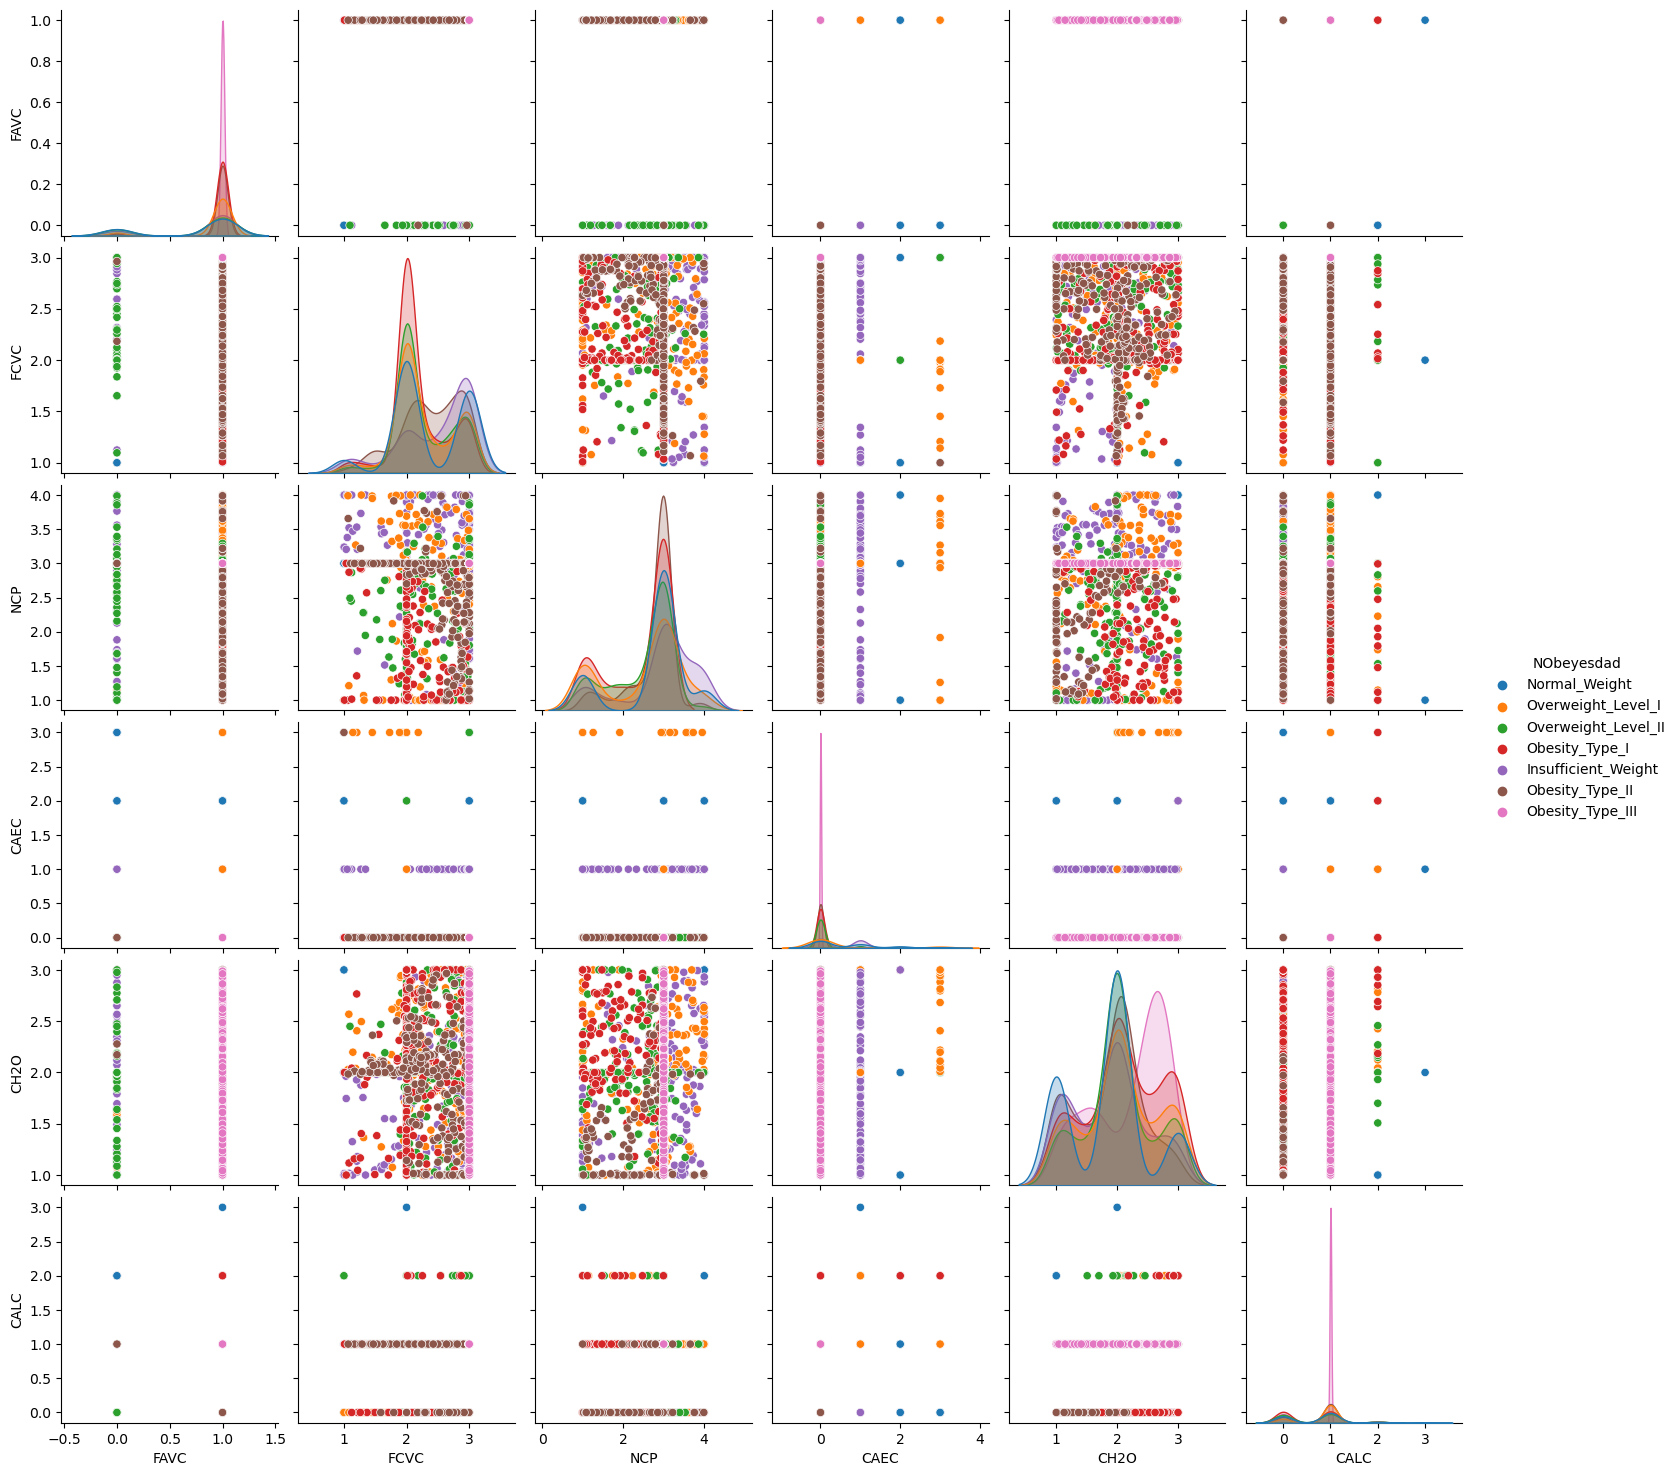

In [197]:
plt.figure(figsize=(15,15))
sns.pairplot(dataAl, hue='NObeyesdad')
plt.show()

A primera vista podemos ver como el grupo de obesidad de tipo 3 (la máxima), esta claramente diferenciado del resto del grupo por su alto consumo de comidas hipercalóricas. Este grupo también está caracterizado por una baja cantidad de comida entre horas pero un alto número de comidas "grandes".

Además podemos observar una segregación del grupo "peso insuficiente" ya que estos frecuentan un bajo consumo de comidas tanto "grande" como entre horas.

Sobre el grupo de sobre peso de nivel 1 podemos mencionar una alta frecuencia de comer entre horas.

Y finalmente, al contrario de lo que se podría pensar, el grupo de sobre peso de nivel 2 no suele consumir comidas hipercalóricas.

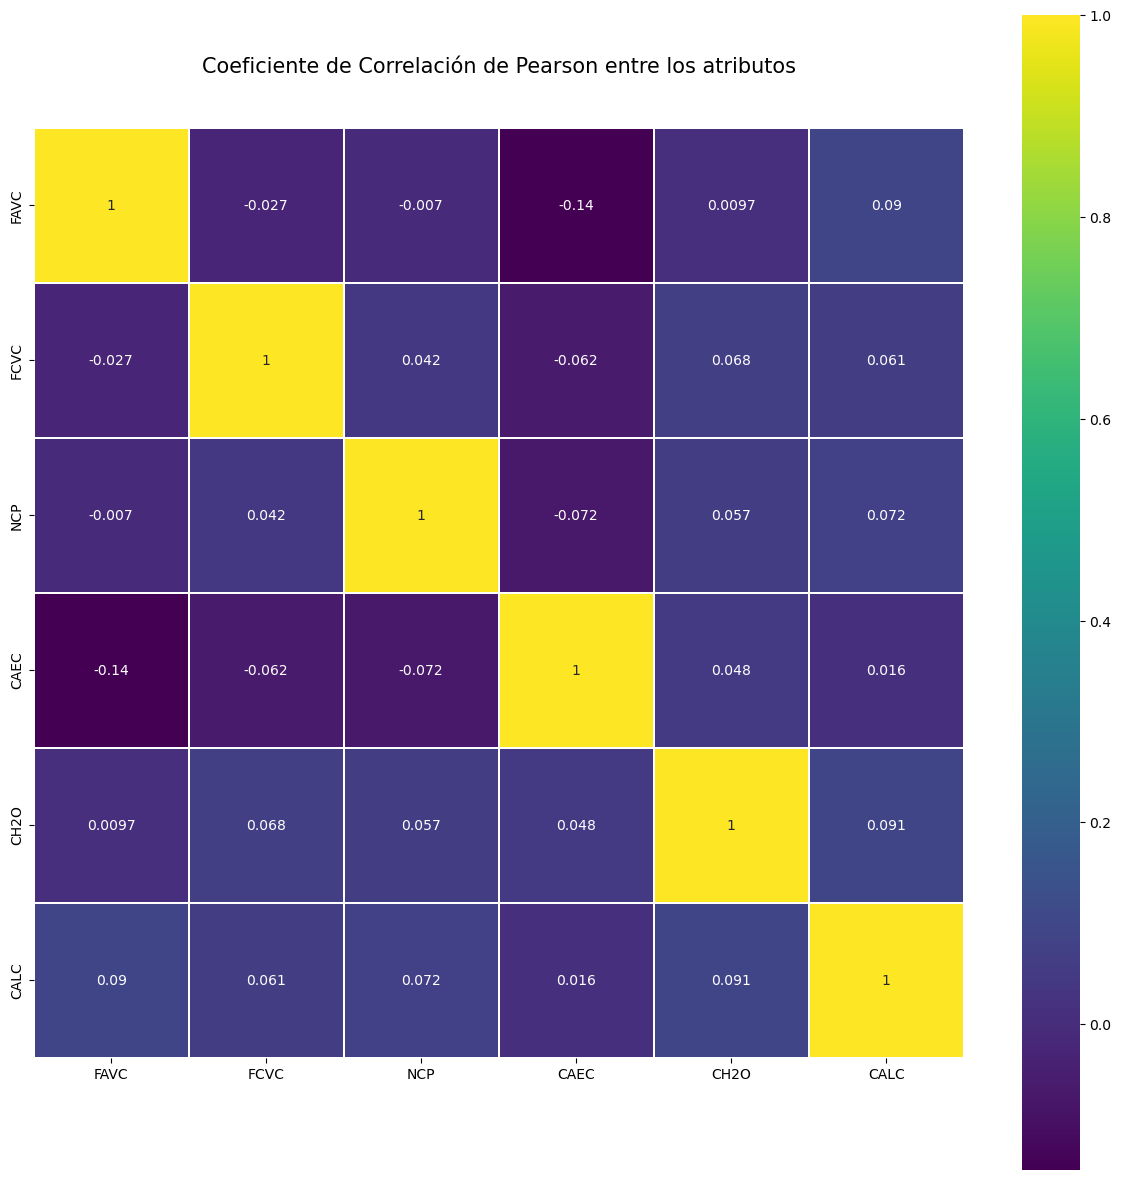

In [198]:
plt.figure(figsize=(15,15))
plt.title('Coeficiente de Correlación de Pearson entre los atributos', y=1.05, size=15)
sns.heatmap(dataAl.loc[:, dataAl.columns[:-1]].astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap='viridis', linecolor='white', annot=True)
plt.show()

A priori no podemos ver una relación clara entre ningún parámetro.

### Árboles de decisión

Habiendo realizado el estudio previo comenzaremos con la construcción del árbol.

In [145]:
arbol =  DecisionTreeClassifier(max_depth = 6)

Como hemos tomado 6 atributos vamos a probar dándole una profunidad máxima de 6

In [199]:
#La tabla sin el valor de clasificación 
datos_clas_al = dataAl.loc[:, dataAl.columns[:-1]]
#La tabla de valores de clasificación
valor_clas_al = dataAl.loc[:, dataAl.columns[-1]]

X_train, X_test, y_train, y_test = \
  train_test_split(datos_clas_al,valor_clas_al,test_size = 0.25,random_state=784)

In [200]:
arbol.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=6)

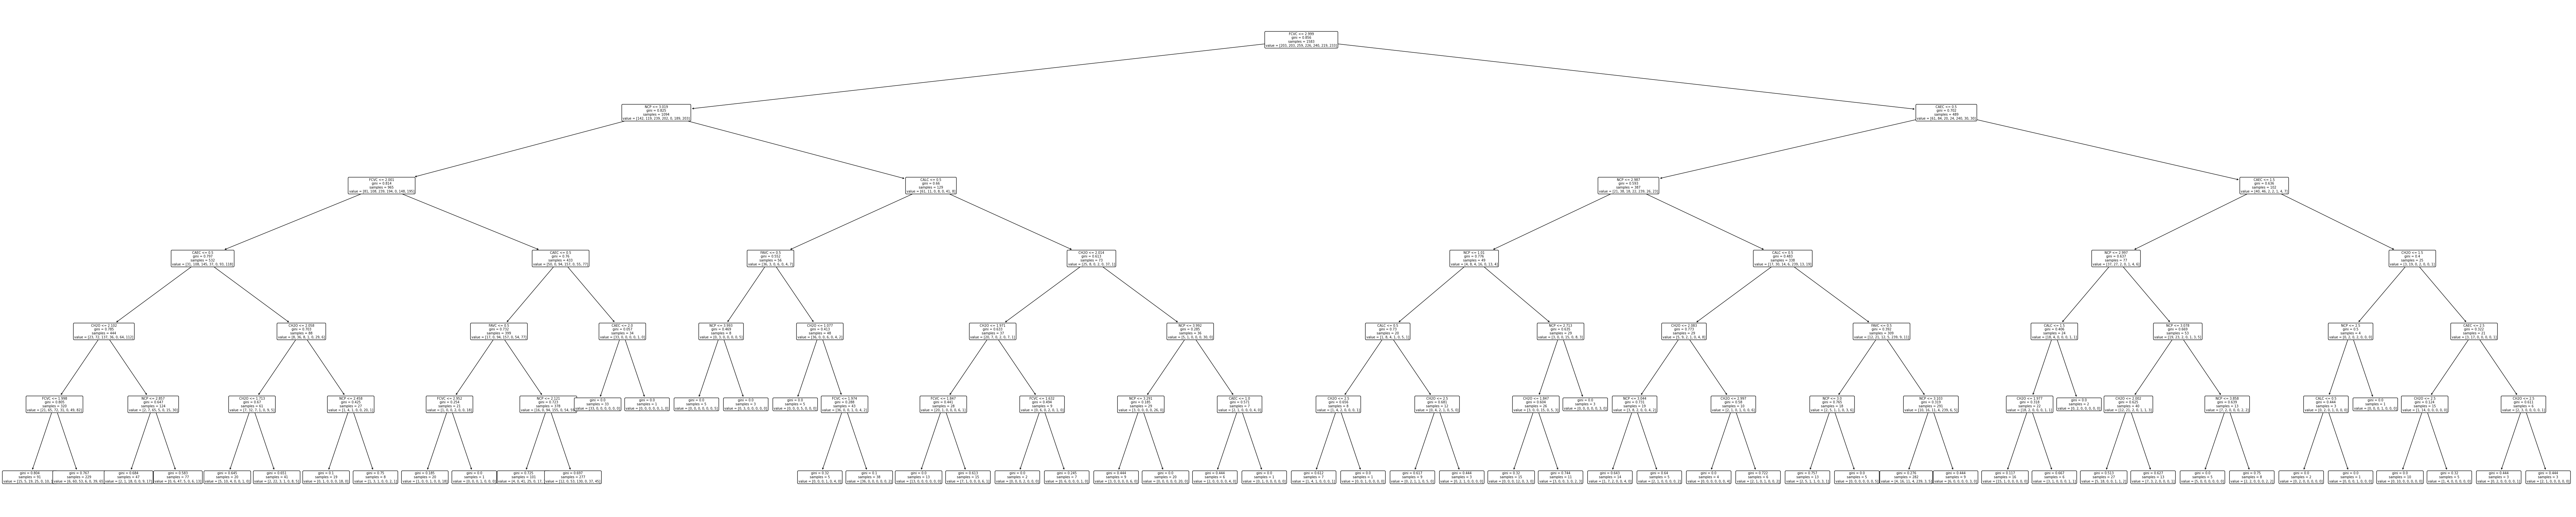

In [201]:

plt.figure(figsize=(100,20))
plot_tree(arbol,rounded=True,fontsize=7, feature_names=  ["FAVC", "FCVC", "NCP", "CAEC", "CH2O", "CALC", "NObeyesdad"])
plt.show()

Veamos el rendimiento de este primer intento

In [202]:
print("Rendimiento en el conjunto de entrenamiento: ",arbol.score(X_train,y_train))
print("Rendimiento en el conjunto de prueba: ",arbol.score(X_test,y_test))
print("Rendimiento en el conjunto total: ",arbol.score(datos_clas_al,valor_clas_al))

Rendimiento en el conjunto de entrenamiento:  0.5799115603284902
Rendimiento en el conjunto de prueba:  0.5568181818181818
Rendimiento en el conjunto total:  0.5741354808147797


Vemos que el rendiminento no es muy alto

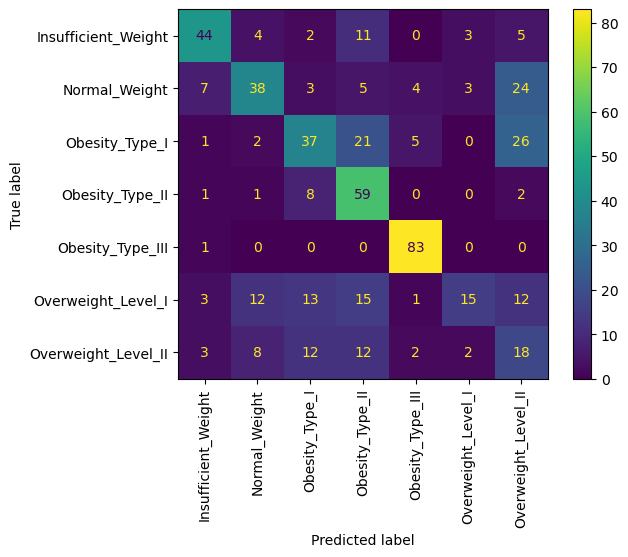

In [204]:
plot_confusion_matrix(arbol, X_test, y_test)  

plt.xticks(range(0, 7), rotation=90)
plt.show()

Vemos que los valores mejores predichos son precisamente aquellos que ya comentamos antes, probablemente el árbol habrá observado las mismas segmentaciones que nosotros

Vamos a intentar mejorar el árbol, para ellos buscamos los mejores parámetros 

In [151]:
t_start = time()
parameters = {
    'criterion':['gini', 'entropy'],
    'max_depth':[None,10],
    'max_leaf_nodes':[None, 25, 50],
    'min_impurity_decrease':[0.0, 0.001, 0.01],
    'min_samples_leaf':[2,6,8, 10],
}

clf = GridSearchCV(DecisionTreeClassifier(random_state=42), parameters, cv=10, scoring='accuracy')

clf.fit(datos_clas_al, valor_clas_al)

print('Se ha tardado {:.2f}s'.format(time() - t_start))
print('Mejores hiperparámetros encontrados:', clf.best_params_)

Se ha tardado 28.52s
Mejores hiperparámetros encontrados: {'criterion': 'gini', 'max_depth': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.001, 'min_samples_leaf': 2}


In [152]:
arbol_final_al = DecisionTreeClassifier(criterion ='entropy', max_features= 'sqrt',max_depth=None,
                                        min_samples_split=2,
                                        min_impurity_decrease=0.001,
                                        min_samples_leaf= 2,random_state=843)
arbol_final_al.fit(datos_clas_al,valor_clas_al)

DecisionTreeClassifier(criterion='entropy', max_features='sqrt',
                       min_impurity_decrease=0.001, min_samples_leaf=2,
                       random_state=843)

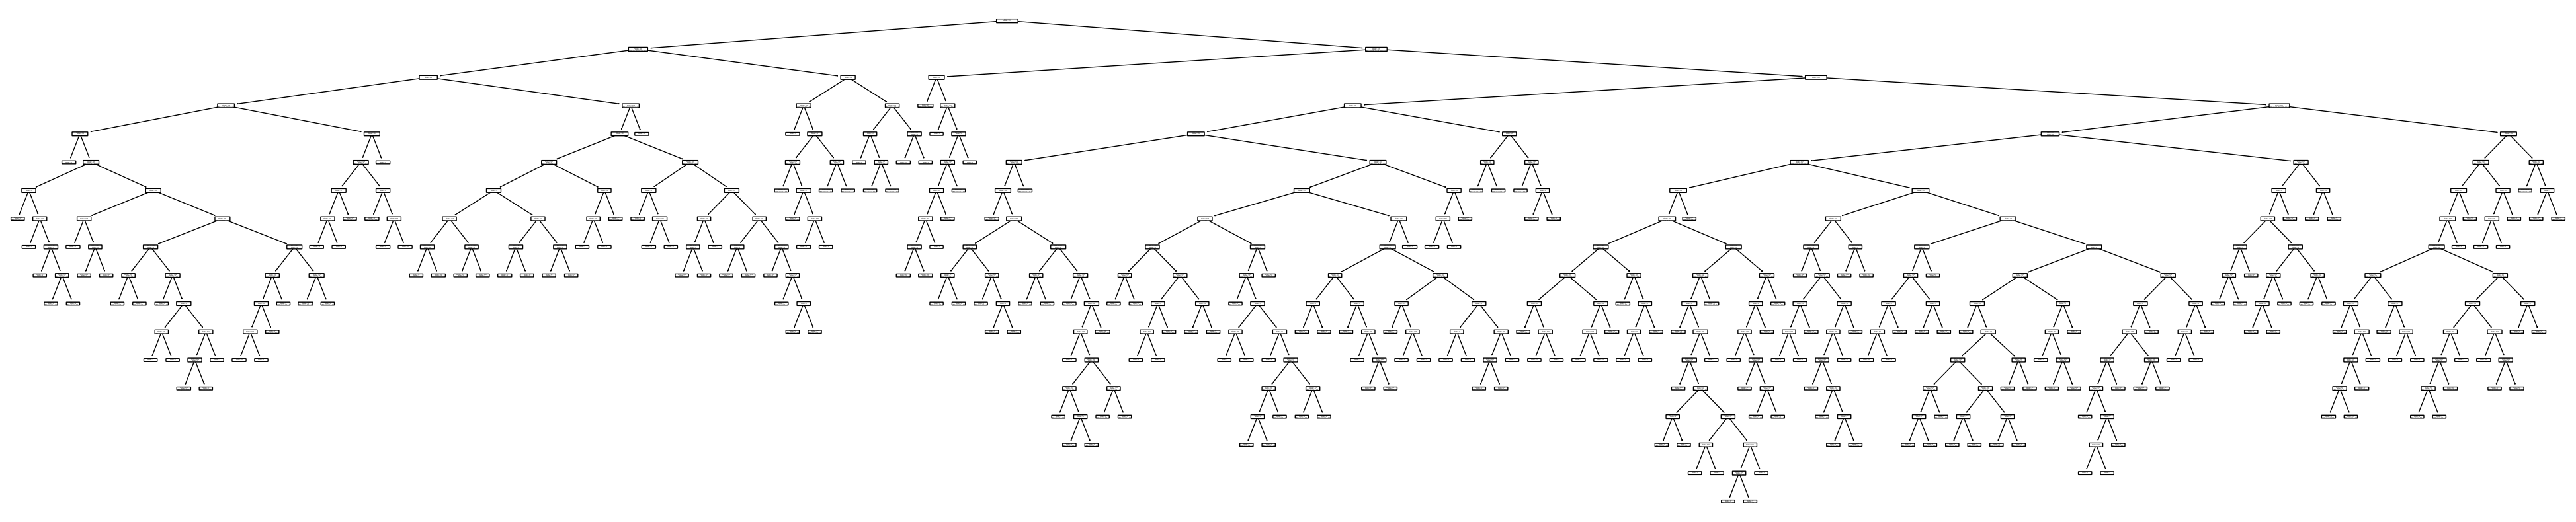

In [153]:
plt.figure(figsize=(50,10))
plot_tree(arbol_final_al,rounded=True,feature_names=  ["FAVC", "FCVC", "NCP", "CAEC", "CH2O", "CALC", "NObeyesdad"])
plt.show()

In [154]:
print("Rendimiento en el conjunto de entrenamiento: ",arbol_final_al.score(X_train,y_train))
print("Rendimiento en el conjunto de prueba: ",arbol_final_al.score(X_test,y_test))
print("Rendimiento en el conjunto total: ",arbol_final_al.score(datos_clas_al,valor_clas_al))

Rendimiento en el conjunto de entrenamiento:  0.7492103600758054
Rendimiento en el conjunto de prueba:  0.75
Rendimiento en el conjunto total:  0.7494078635717669


## Atributos No Alimenticios

Ahora haremos el mismo estudio con los atributos no relacionados con la alimentación, estos son: family_history_with_overweight, SMOKE, SCC, FAF, TUE, MTRANS. Procedermos de forma análoga, cambiando los atributos categóricos por numéricos.

In [155]:
dataNAL = data.loc[:, ["family_history_with_overweight", "SMOKE", "SCC", "FAF", "TUE", "MTRANS", "NObeyesdad"]]
dataNAL

,family_history_with_overweight,SMOKE,SCC,FAF,TUE,MTRANS,NObeyesdad
0,yes,no,no,0.000000,1.000000,Public_Transportation,Normal_Weight
1,yes,yes,yes,3.000000,0.000000,Public_Transportation,Normal_Weight
2,yes,no,no,2.000000,1.000000,Public_Transportation,Normal_Weight
3,no,no,no,2.000000,0.000000,Walking,Overweight_Level_I
4,no,no,no,0.000000,0.000000,Public_Transportation,Overweight_Level_II
...,...,...,...,...,...,...,...
2106,yes,no,no,1.676269,0.906247,Public_Transportation,Obesity_Type_III
2107,yes,no,no,1.341390,0.599270,Public_Transportation,Obesity_Type_III
2108,yes,no,no,1.414209,0.646288,Public_Transportation,Obesity_Type_III
2109,yes,no,no,1.139107,0.586035,Public_Transportation,Obesity_Type_III


In [156]:
for i in ["family_history_with_overweight","SMOKE","SCC","MTRANS"]:
    cambio = dataNAL[i].factorize()
    dataNAL[i] = cambio[0]
dataNAL

,family_history_with_overweight,SMOKE,SCC,FAF,TUE,MTRANS,NObeyesdad
0,0,0,0,0.000000,1.000000,0,Normal_Weight
1,0,1,1,3.000000,0.000000,0,Normal_Weight
2,0,0,0,2.000000,1.000000,0,Normal_Weight
3,1,0,0,2.000000,0.000000,1,Overweight_Level_I
4,1,0,0,0.000000,0.000000,0,Overweight_Level_II
...,...,...,...,...,...,...,...
2106,0,0,0,1.676269,0.906247,0,Obesity_Type_III
2107,0,0,0,1.341390,0.599270,0,Obesity_Type_III
2108,0,0,0,1.414209,0.646288,0,Obesity_Type_III
2109,0,0,0,1.139107,0.586035,0,Obesity_Type_III


<Figure size 1500x1500 with 0 Axes>

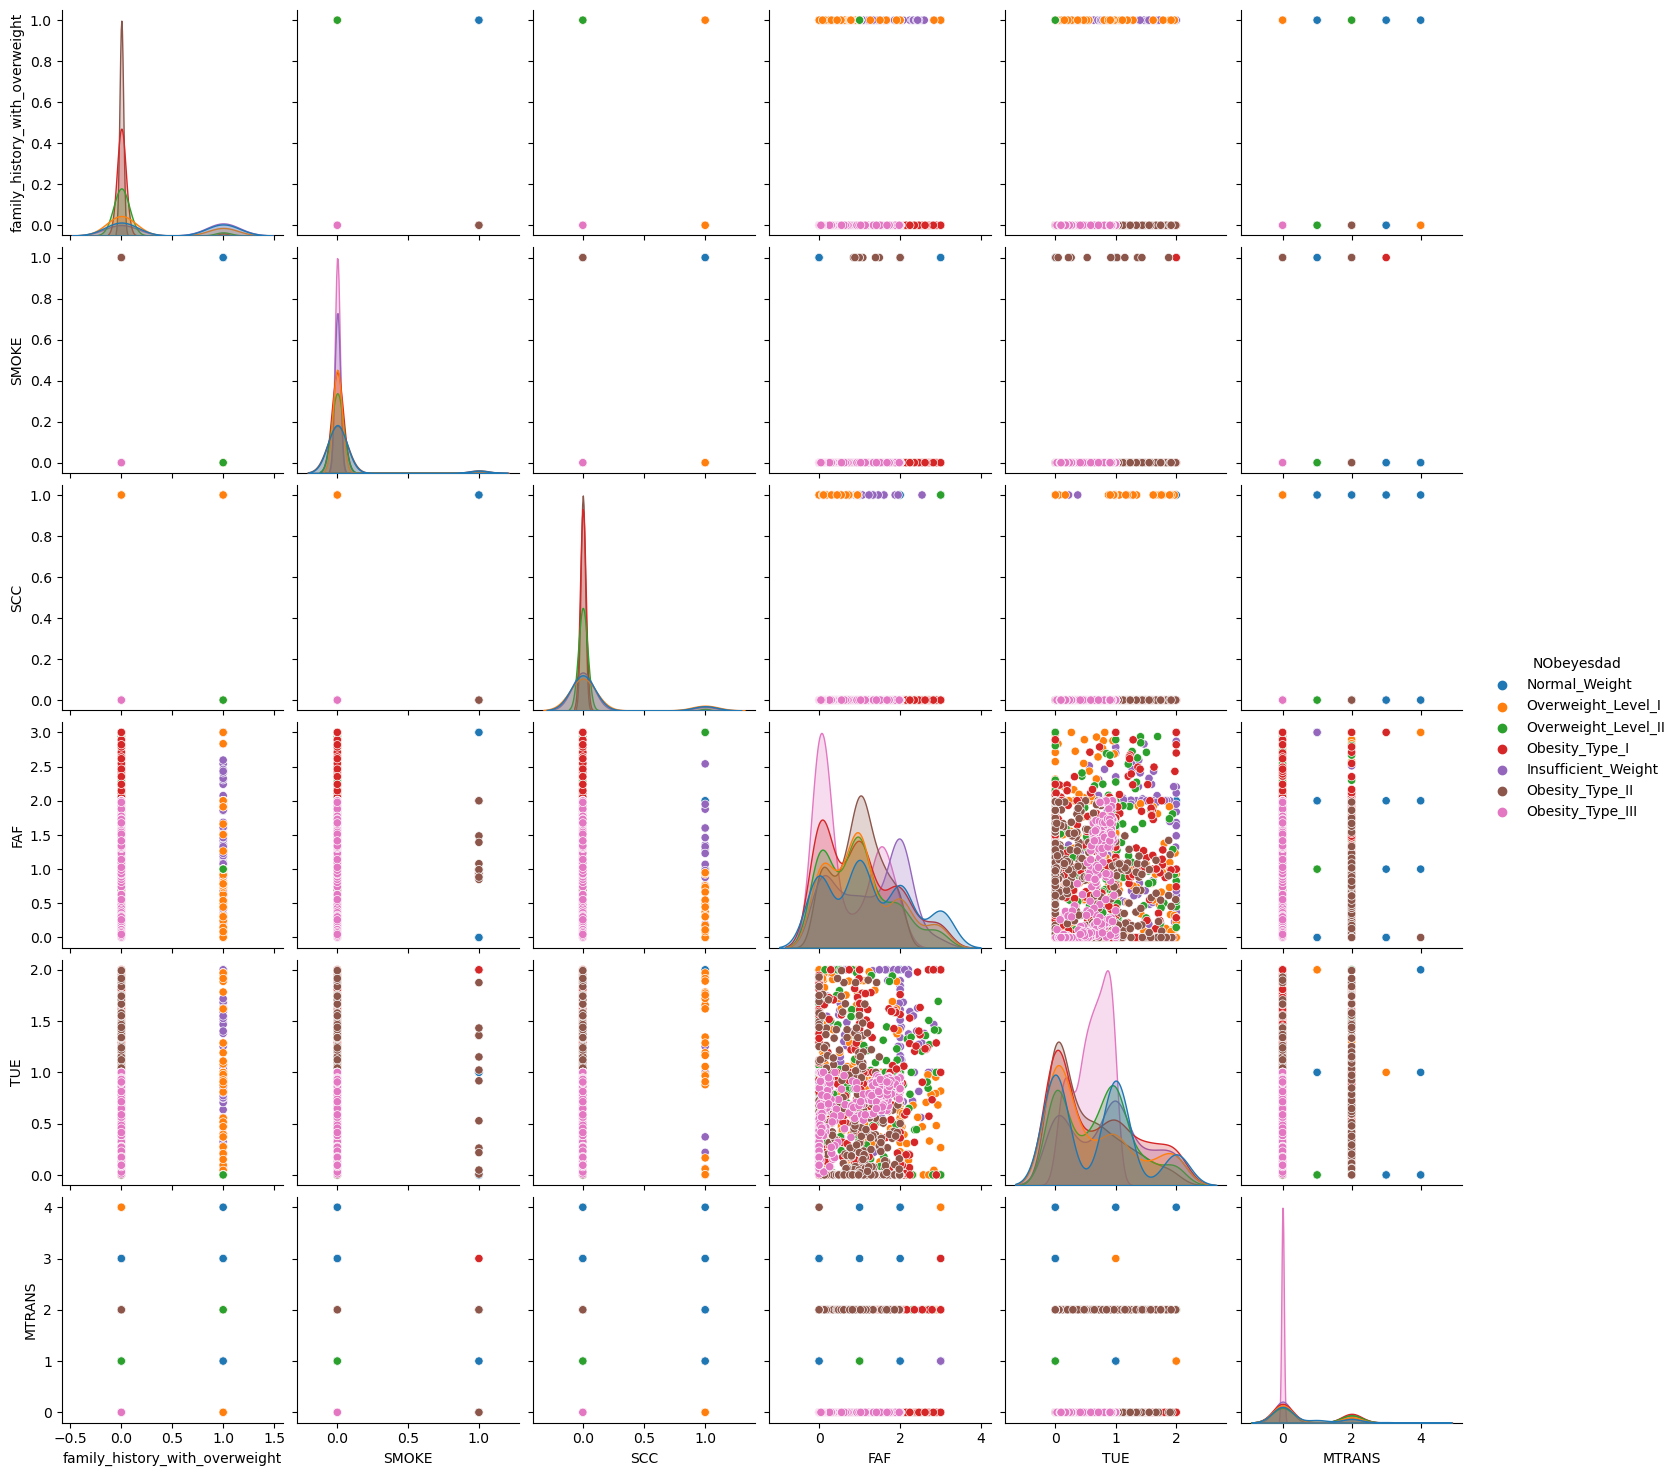

In [157]:
plt.figure(figsize=(15,15))
sns.pairplot(dataNAL, hue='NObeyesdad')
plt.show()

Vemos que los datos con el valor obesidad de tipo 3 tienen todos un historial familiar con sobrepeso y no fuman. También es clara la linea por debajo de 1.0 den el parámetro TUE.

Se puede observar además que los clasificados con peso insuficiente tiene un alto monitoreo de su consumo calórico





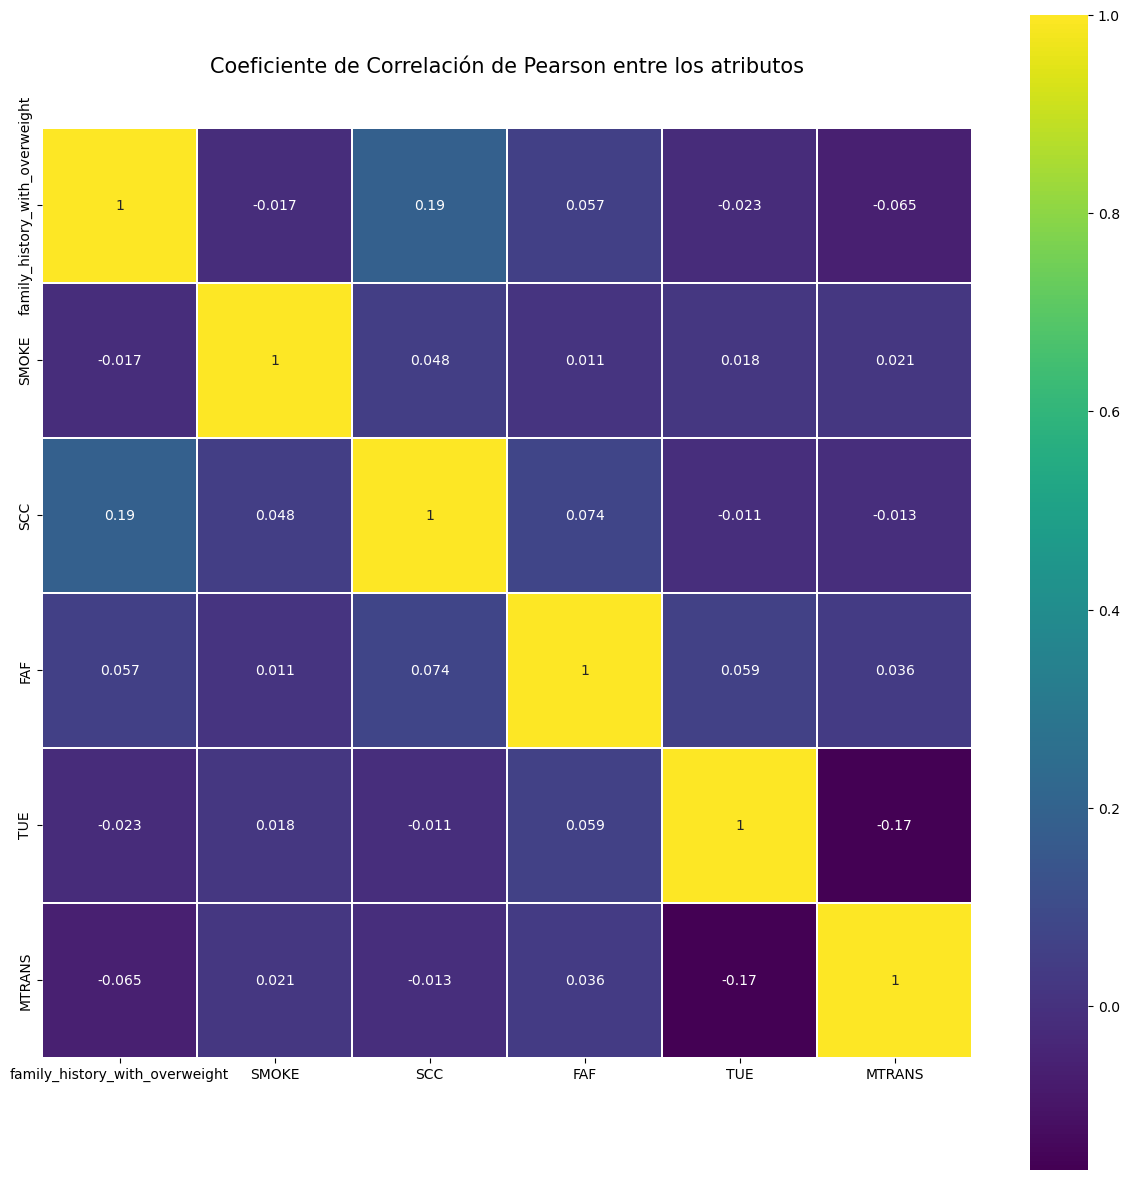

In [158]:
plt.figure(figsize=(15,15))
plt.title('Coeficiente de Correlación de Pearson entre los atributos', y=1.05, size=15)
sns.heatmap(dataNAL.loc[:, dataNAL.columns[:-1]].astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap='viridis', linecolor='white', annot=True)
plt.show()

En este caso tampoco se aprecio ninguna relación entre los parámetros escogidos

### Árboles de decisión

De la misma manera que antes probaremos un primer árbol de profundidad 6 ya que tenemos 7 atributos ahora también

In [159]:
arbol2 =  DecisionTreeClassifier(max_depth = 6)

In [160]:
#La tabla sin el valor de clasificación 
datos_clas_nal = dataNAL.loc[:, dataNAL.columns[:-1]]
#La tabla de valores de clasificación
valor_clas_nal = dataNAL.loc[:, dataNAL.columns[-1]]

X_train, X_test, y_train, y_test = \
  train_test_split(datos_clas_nal,valor_clas_nal,test_size = 0.25,random_state=784)

In [161]:
arbol2.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=6)

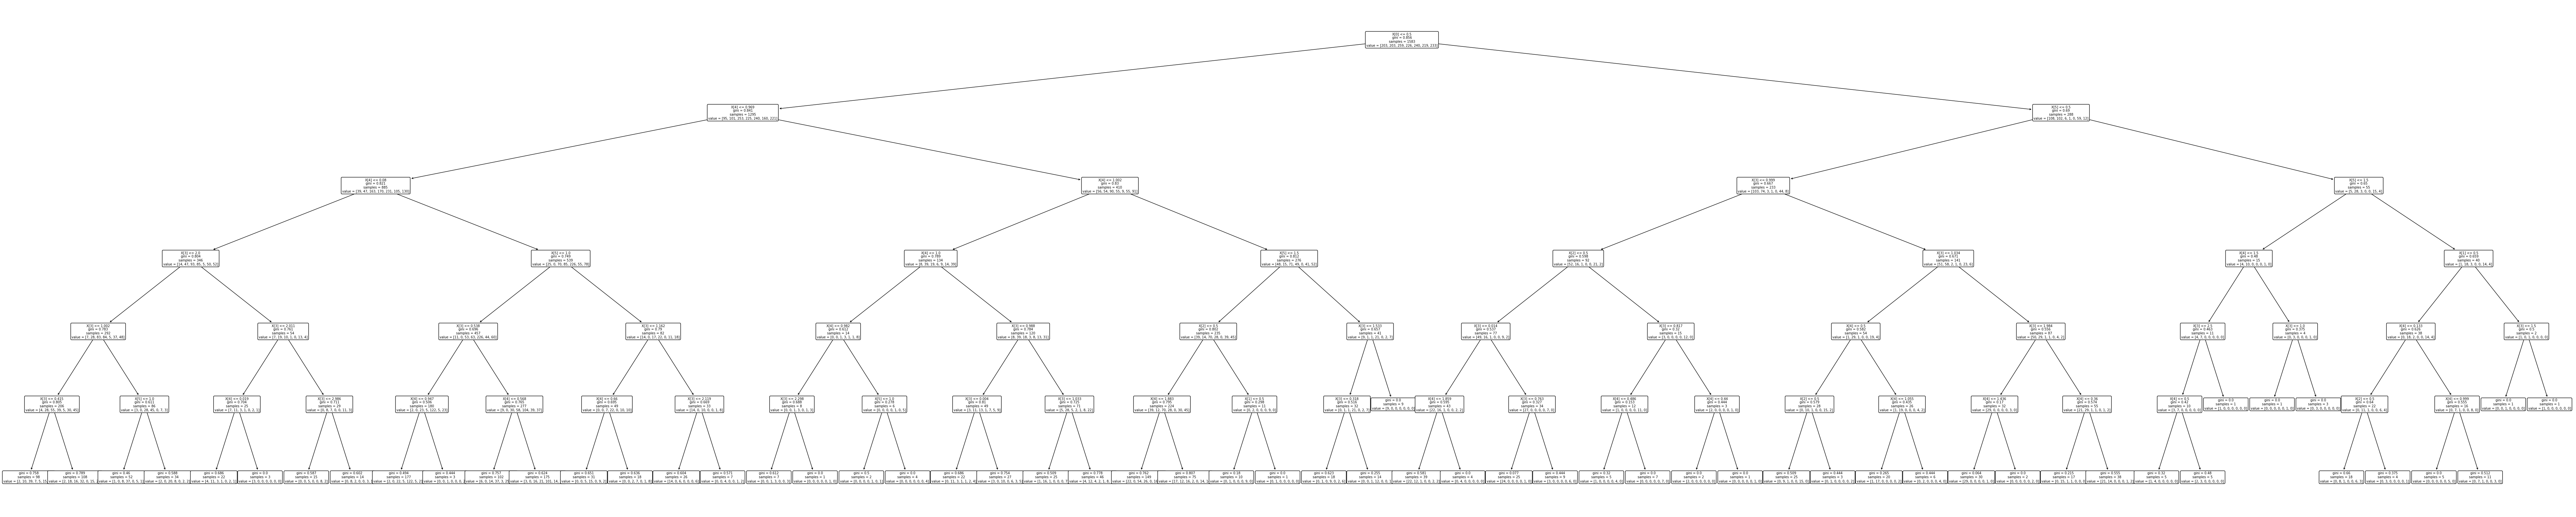

In [162]:

plt.figure(figsize=(100,20))
plot_tree(arbol2,rounded=True,fontsize=7)
plt.show()

Veamos el rendimiento de este primero intento

In [163]:
print("Rendimiento en el conjunto de entrenamiento: ",arbol2.score(X_train,y_train))
print("Rendimiento en el conjunto de prueba: ",arbol2.score(X_test,y_test))
print("Rendimiento en el conjunto total: ",arbol2.score(datos_clas_nal,valor_clas_nal))

Rendimiento en el conjunto de entrenamiento:  0.5337965887555275
Rendimiento en el conjunto de prueba:  0.5227272727272727
Rendimiento en el conjunto total:  0.5310279488394126


El rendiento es relativamente bajo, veamos como podemos arreglarlo

In [164]:
t_start = time()
parameters = {
    'criterion':['gini', 'entropy'],
    'max_depth':[None,10,12],
    'max_features':['sqrt', 'log2'],
    'max_leaf_nodes':[None, 25, 50],
    'min_impurity_decrease':[0.0, 0.001, 0.01],
    'min_samples_leaf':[8, 10, 12, 14],
    'min_samples_split':[2, 4]
}

clf = GridSearchCV(DecisionTreeClassifier(random_state=42), parameters, cv=5, scoring='accuracy')

clf.fit(datos_clas_nal, valor_clas_nal)

print('Se ha tardado {:.2f}s'.format(time() - t_start))
print('Mejores hiperparámetros encontrados:', clf.best_params_)

Se ha tardado 53.51s
Mejores hiperparámetros encontrados: {'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 8, 'min_samples_split': 2}


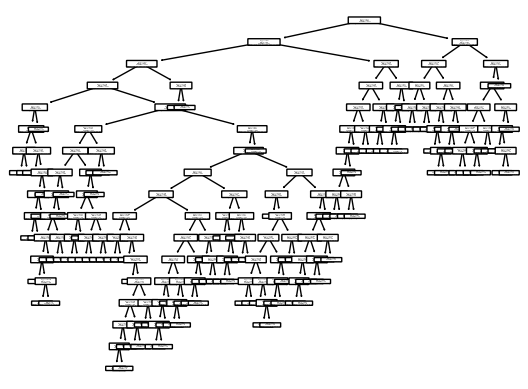

In [165]:
arbol_final_nal = DecisionTreeClassifier(criterion ='gini', max_features= 'sqrt',max_depth=None,max_leaf_nodes=None,
                                        min_samples_split=2,
                                        min_impurity_decrease=0.0,
                                        min_samples_leaf= 8,random_state=42)
arbol_final_nal.fit(datos_clas_nal,valor_clas_nal)
plot_tree(arbol_final_nal,rounded=True)
plt.show()

In [166]:
print("Rendimiento en el conjunto de entrenamiento: ",arbol_final_nal.score(X_train,y_train))
print("Rendimiento en el conjunto de prueba: ",arbol_final_nal.score(X_test,y_test))
print("Rendimiento en el conjunto total: ",arbol_final_nal.score(datos_clas_nal,valor_clas_nal))

Rendimiento en el conjunto de entrenamiento:  0.5325331648768161
Rendimiento en el conjunto de prueba:  0.5700757575757576
Rendimiento en el conjunto total:  0.541923259118901


Aunque ha mejorado el rendimiento en el conjunto de entrenamiento y el total sigue siendo menor al árbol obtenido en el apartado anterior. Por lo que podemos inferir que, aunque el deporte sea relevante, los mejores hábitos para evitar la obesidad serán los hábitos alimenticios.

## Árbol Final


Por último veremos un árbol reuniendo todos los parámetros anteriores, tanto alimenticios como no, y usaremos el algoritmo CART, ya integrado en Scikit-learn, para ordenarlos por importancia. Así corroboraremos el resultado anterior y obtendremos el mejor árbol posible para la predicción de la obesidad según el estilo de vida

Primero probemos a construir un árbol usando todos los argumentos.

In [206]:
#La tabla sin el valor de clasificación 

datos_clas = data.loc[:, data.columns[4:-1]]
#La tabla de valores de clasificación
valor_clas = dataAl.loc[:, data.columns[-1]]
for i in ["FAVC","CAEC","CALC","family_history_with_overweight","SMOKE","SCC","MTRANS"]:
    cambio = data[i].factorize()
    data[i] = cambio[0]

    

X_train, X_test, y_train, y_test = \
  train_test_split(datos_clas,valor_clas,test_size = 0.25,random_state=784)
arbolTotal = DecisionTreeClassifier()

arbolTotal.fit(X_train,y_train)


DecisionTreeClassifier()

In [207]:
print("Rendimiento en el conjunto de entrenamiento: ",arbolTotal.score(X_train,y_train))
print("Rendimiento en el conjunto de prueba: ",arbolTotal.score(X_test,y_test))
print("Rendimiento en el conjunto total: ",arbolTotal.score(datos_clas,valor_clas))

Rendimiento en el conjunto de entrenamiento:  0.9962097283638661
Rendimiento en el conjunto de prueba:  0.6685606060606061
Rendimiento en el conjunto total:  0.9142586451918522


Se observa un sobreajuste en este árbol, busquemos los mejores parámetros para reducirlo.

El parámetro: family_history_with_overweight tiene un Score: 0.04741809008206965
El parámetro: FAVC tiene un Score: 0.03282819165068169
El parámetro: FCVC tiene un Score: 0.17131528164847354
El parámetro: NCP tiene un Score: 0.11629751517086243
El parámetro: CAEC tiene un Score: 0.07549450746070821
El parámetro: SMOKE tiene un Score: 0.005788209335648648
El parámetro: CH2O tiene un Score: 0.13115667982658816
El parámetro: SCC tiene un Score: 0.011020330150816385
El parámetro: FAF tiene un Score: 0.10785585641378714
El parámetro: TUE tiene un Score: 0.1542103703181203
El parámetro: CALC tiene un Score: 0.08077198026857119
El parámetro: MTRANS tiene un Score: 0.0658429876736727


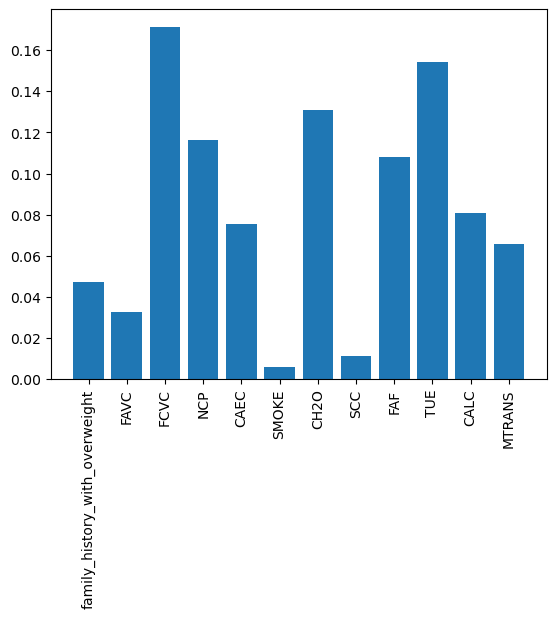

In [208]:
model = DecisionTreeClassifier()
model.fit(datos_clas, valor_clas)
importance = model.feature_importances_
for i,v in zip(datos_clas,importance):
    print(f'El parámetro: {i} tiene un Score: {v}')
plt.bar([x for x in datos_clas], importance)
plt.xticks(rotation=90)
plt.show()

Escogemos de los parámetros solamente aquellos que tengan un score de 0.1 o más

In [209]:
param_clasF = [x for x,i in zip(datos_clas,importance) if i in [i for i in importance if int(str(i)[2])==1]]
print("Los mejores parámetros son:")
for i in param_clasF:
    print(i)

Los mejores parámetros son:
FCVC
NCP
CH2O
FAF
TUE


Algunos de los parámetros escogidos son los que salieron mencionados en el estudio previo

In [210]:
#La tabla sin el valor de clasificación 

datos_clasF = data[param_clasF]
#La tabla de valores de clasificación
valor_clasF = dataAl.loc[:, data.columns[-1]]



In [ ]:

arbolFinal = DecisionTreeClassifier()
arbolFinal.fit(datos_clasF,valor_clasF)
plot_tree(arbolFinal)
plt.show()

In [189]:
print("Rendimiento en el conjunto de entrenamiento: ",arbolFinal.score(X_train[param_clasF],y_train))
print("Rendimiento en el conjunto de prueba: ",arbolFinal.score(X_test[param_clasF],y_test))
print("Rendimiento en el conjunto total: ",arbolFinal.score(datos_clasF,valor_clasF))

Rendimiento en el conjunto de entrenamiento:  0.915982312065698
Rendimiento en el conjunto de prueba:  0.9166666666666666
Rendimiento en el conjunto total:  0.916153481762198


Hemos podido construir un mejor árbol. Se podría mejorar usando el search grid para buscar los mejores hiperparámetros del árbol